# Preparing data

In [0]:
install.packages(c("quantmod", "tidyverse", "versions")) 

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [0]:
knitr::opts_chunk$set(echo=TRUE)
library(quantmod)
library(tidyverse)
options("getSymbols.yahoo.warning"=FALSE)

Pull down stock data for TSLA using Get Symbols

In [0]:
tsla <- getSymbols("TSLA", auto.assign = F)
head(tsla)

           TSLA.Open TSLA.High TSLA.Low TSLA.Close TSLA.Volume TSLA.Adjusted
2010-06-29     19.00     25.00    17.54      23.89    18766300         23.89
2010-06-30     25.79     30.42    23.30      23.83    17187100         23.83
2010-07-01     25.00     25.92    20.27      21.96     8218800         21.96
2010-07-02     23.00     23.10    18.71      19.20     5139800         19.20
2010-07-06     20.00     20.00    15.83      16.11     6866900         16.11
2010-07-07     16.40     16.63    14.98      15.80     6921700         15.80

Store closing price adjusted for stock splits (two ways)

In [0]:
tsla_close <- tsla$TSLA.Close
head(tsla_close)

tsla_close2 <- Ad(tsla)
head(tsla_close2)

           TSLA.Close
2010-06-29      23.89
2010-06-30      23.83
2010-07-01      21.96
2010-07-02      19.20
2010-07-06      16.11
2010-07-07      15.80

           TSLA.Adjusted
2010-06-29         23.89
2010-06-30         23.83
2010-07-01         21.96
2010-07-02         19.20
2010-07-06         16.11
2010-07-07         15.80

Lag function

In [0]:
head(tsla_close)
head(Lag(tsla_close, 2))

           TSLA.Close
2010-06-29      23.89
2010-06-30      23.83
2010-07-01      21.96
2010-07-02      19.20
2010-07-06      16.11
2010-07-07      15.80

           Lag.2
2010-06-29    NA
2010-06-30    NA
2010-07-01 23.89
2010-07-02 23.83
2010-07-06 21.96
2010-07-07 19.20

Remove scientific notation

In [0]:
options(scipen = 9999)

Create daily change percent vector

In [0]:
daily_change <- tsla_close / Lag(tsla_close, 1) - 1
head(daily_change)

             TSLA.Close
2010-06-29           NA
2010-06-30 -0.002511469
2010-07-01 -0.078472556
2010-07-02 -0.125682975
2010-07-06 -0.160937492
2010-07-07 -0.019242767

Look at Histogram of Percentage change (identify risk and signal)

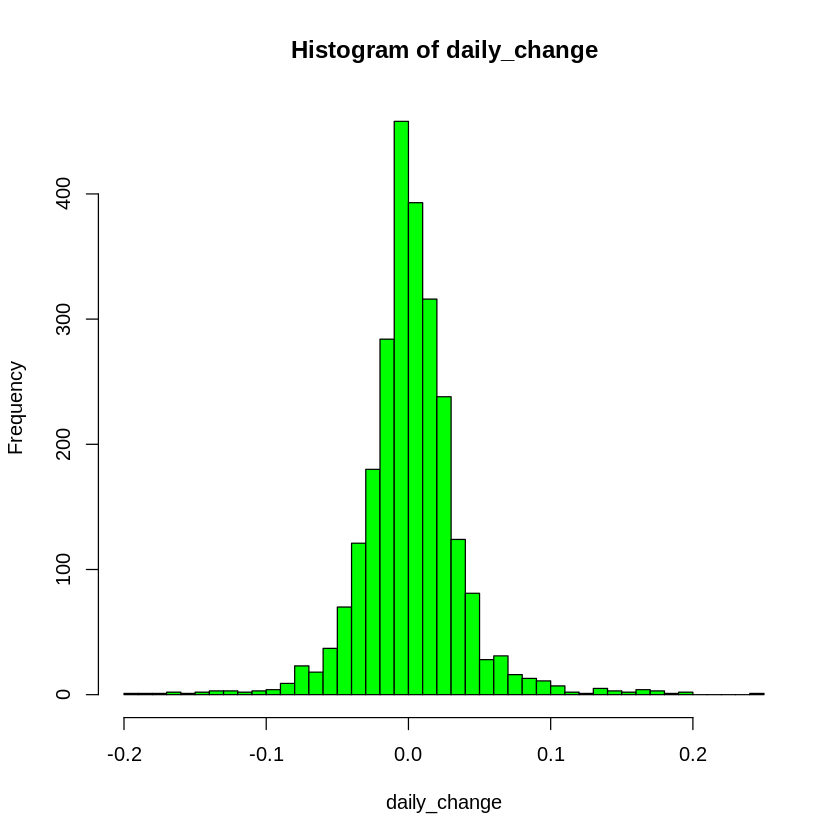

In [0]:
hist(daily_change, 40, col="green")

# Simple Threshold Filter

We'll take it as a signal if the daily percentage change is more than 0.04

In [0]:
buy_signal <- .005

Loop over all trading days except the first

buy_signal == 0.005,\
tsla_close == data,\
daily_change == %change,\
signal == 1 or 0, buy/sell

In [0]:
signal <- c(NULL)
for(i in 2:length(tsla_close)){
  if(daily_change[i] > buy_signal){
    signal[i] <- 1
  } else
    signal[i] <- 0
}
head(signal, 40)

[1] NA  0  0  0  0  0  1  0  0  1  1  0  1  1  0  0  1  1  0  0  1  0  0  1  1
[26]  0  0  0  0  0  0  0  1  1  1  0  0  1  1  0

Reclassify signal to an xts obj (tying it to a date)

In [0]:
signal <- reclass(signal, tsla_close)
head(signal, 20)

Warning message:
“timezone of object (UTC) is different than current timezone ().”


           [,1]
2010-06-29   NA
2010-06-30    0
2010-07-01    0
2010-07-02    0
2010-07-06    0
2010-07-07    0
2010-07-08    1
2010-07-09    0
2010-07-12    0
2010-07-13    1
2010-07-14    1
2010-07-15    0
2010-07-16    1
2010-07-19    1
2010-07-20    0
2010-07-21    0
2010-07-22    1
2010-07-23    1
2010-07-26    0
2010-07-27    0

Chart the series

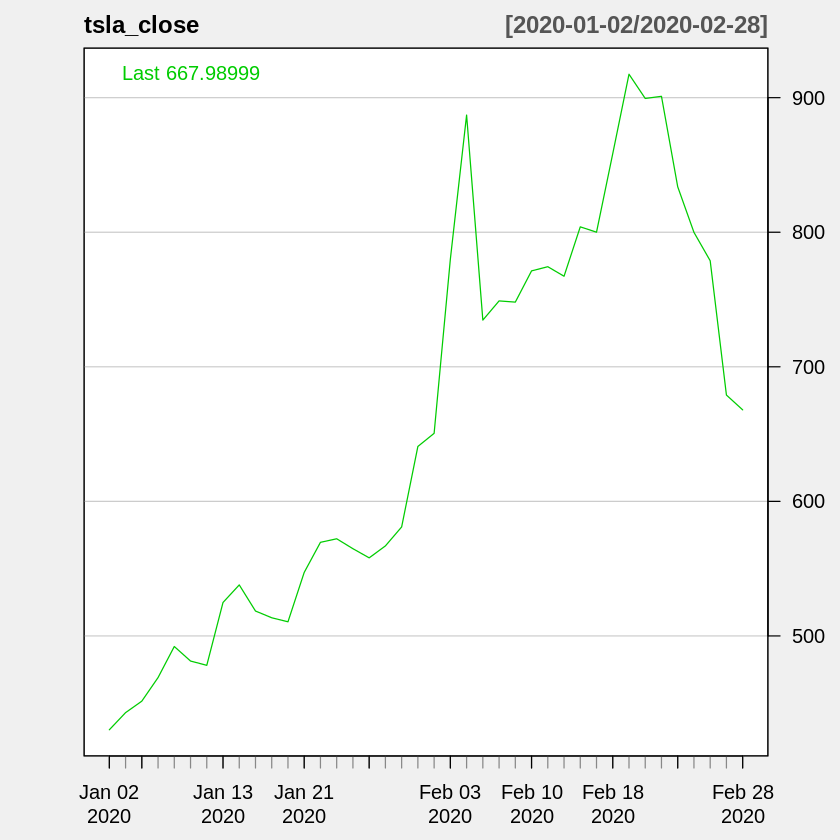

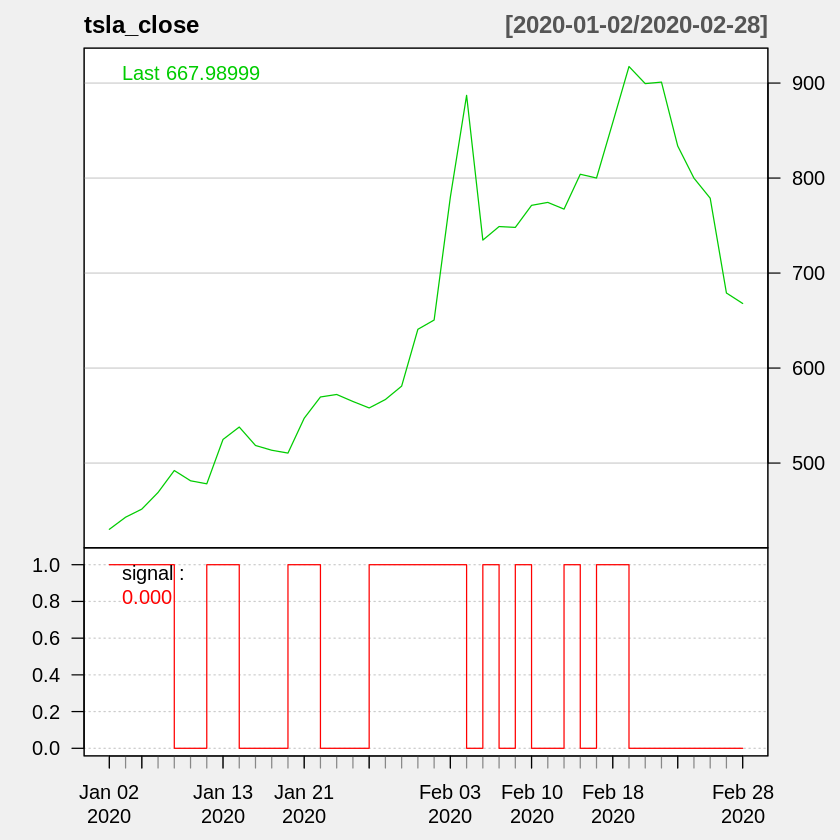

In [0]:
chartSeries(
  tsla_close,
  type = "l",
  subset = "2020-01::2020-02",
  theme = chartTheme("white")
)
addTA(signal, type = "S", col = "red")

Summary

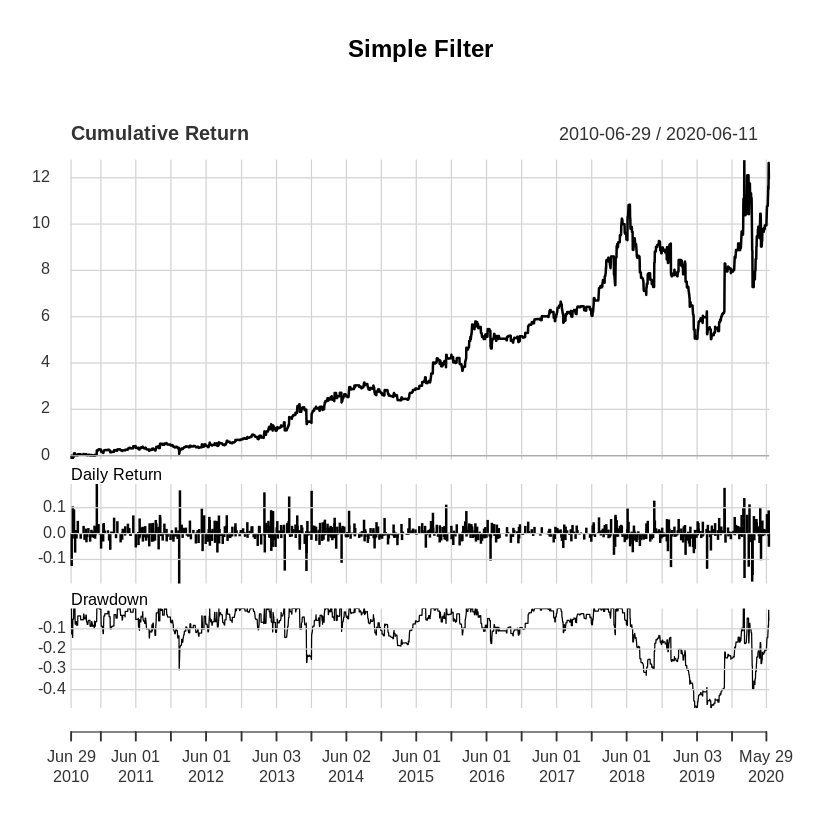

In [0]:
trade <- Lag(signal, 1)
return <- dailyReturn(tsla) * trade
names(return) = "filter"
charts.PerformanceSummary(return, main = "Simple Filter")

# RSI Filter

In [0]:
install.packages("PerformanceAnalytics")
library(PerformanceAnalytics)

options("getSymbols.warning4.0"=FALSE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Prepare new data (Microsoft)

In [0]:
getSymbols("MSFT")
price <- Cl(MSFT) # close price
r <- price / Lag(price) - 1 # % of price change
delta <- .005 # threshold
signal <- c(0) # first date has no signal

# Loop over all trading days except the first
for(i in 2:length(price)){
  if(r[i] > delta){
    signal[i] <- 1
  } else
    signal[i] <- 0
}

signal <- reclass(signal, price)
tail(signal, n = 20)

[1] "MSFT"

Warning message:
“timezone of object (UTC) is different than current timezone ().”


           [,1]
2020-05-14    0
2020-05-15    1
2020-05-18    1
2020-05-19    0
2020-05-20    1
2020-05-21    0
2020-05-22    0
2020-05-26    0
2020-05-27    0
2020-05-28    0
2020-05-29    1
2020-06-01    0
2020-06-02    1
2020-06-03    0
2020-06-04    0
2020-06-05    1
2020-06-08    1
2020-06-09    1
2020-06-10    1
2020-06-11    0

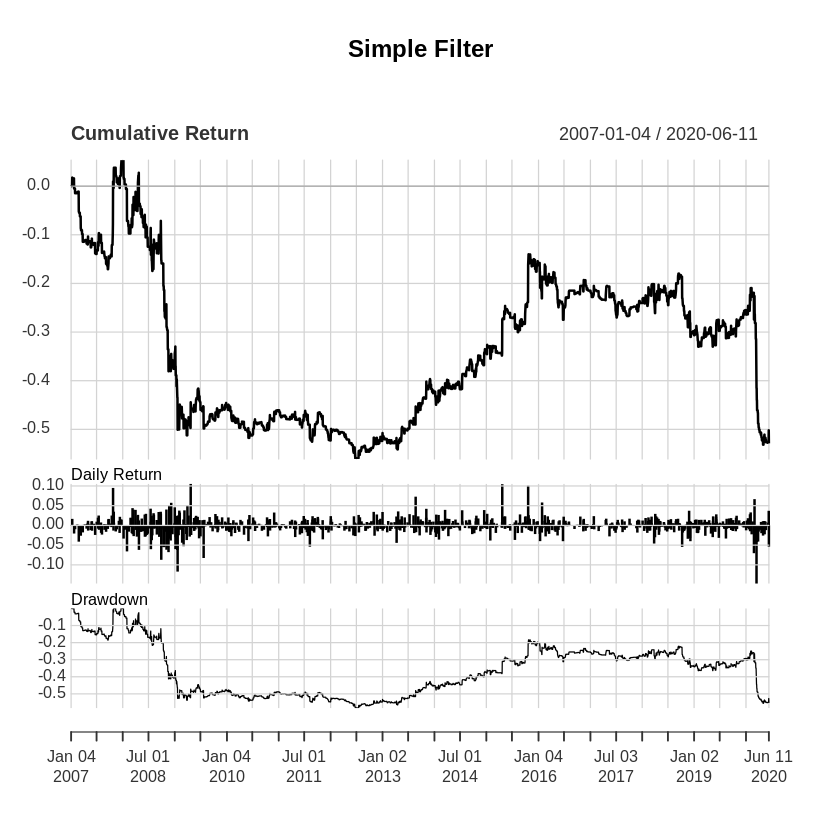

In [0]:
trade <- Lag(signal, 1)
return_simple <- dailyReturn(MSFT) * trade
names(return_simple) = "filter"
charts.PerformanceSummary(return_simple, main = "Simple Filter")

Making an RSI index

In [0]:
day <- 14
price <- Cl(MSFT)
signal <- c(0)
rsi <- RSI(price, day)

"For loop" for RSI Filter

In [0]:
signal[1:day + 1] <- 0

for(i in (day + 1):length(price)){
  if(rsi[i] < 50){
    signal[i] <- 1
  } else
    signal[i] <- 0
}
signal <- reclass(signal, Cl(MSFT))
head(signal, 20)

Warning message:
“timezone of object (UTC) is different than current timezone ().”


           [,1]
2007-01-03    0
2007-01-04    0
2007-01-05    0
2007-01-08    0
2007-01-09    0
2007-01-10    0
2007-01-11    0
2007-01-12    0
2007-01-16    0
2007-01-17    0
2007-01-18    0
2007-01-19    0
2007-01-22    0
2007-01-23    0
2007-01-24    0
2007-01-25    0
2007-01-26    0
2007-01-29    0
2007-01-30    0
2007-01-31    0

Daily Trades Return

In [0]:
trade_lag <- Lag(signal)
return_RSI <- dailyReturn(MSFT) * trade_lag

Plot the summary

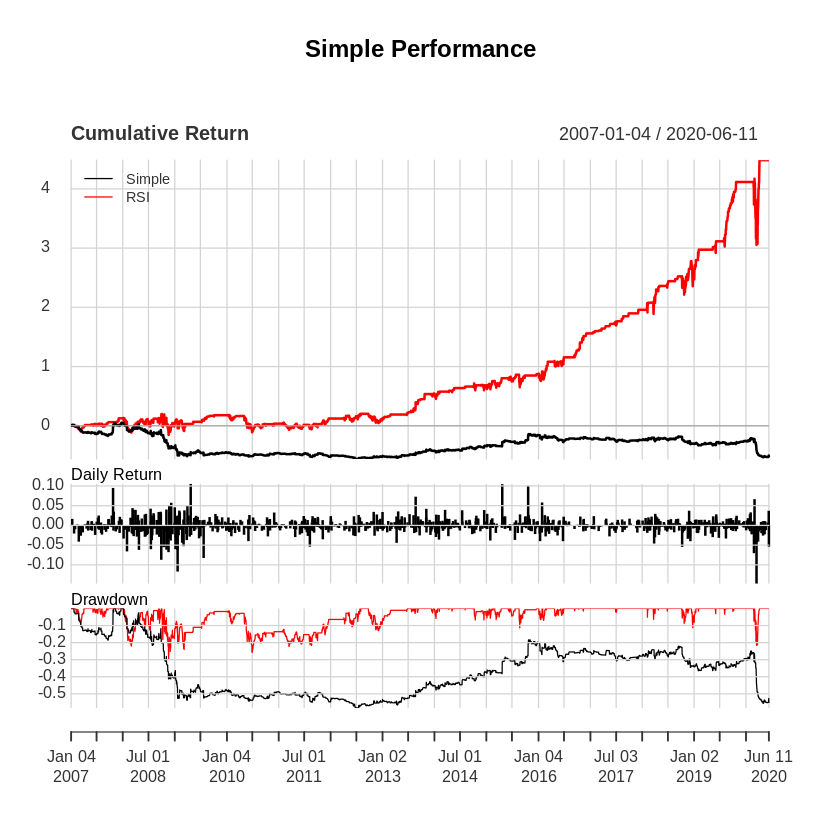

In [0]:
names(return_simple) = "Simple"
names(return_RSI) = "RSI"
return_combined = cbind(return_simple, return_RSI)
charts.PerformanceSummary(return_combined, name = "Simple filter vs RSI filter")

Same for Tesla

[1] "TSLA"

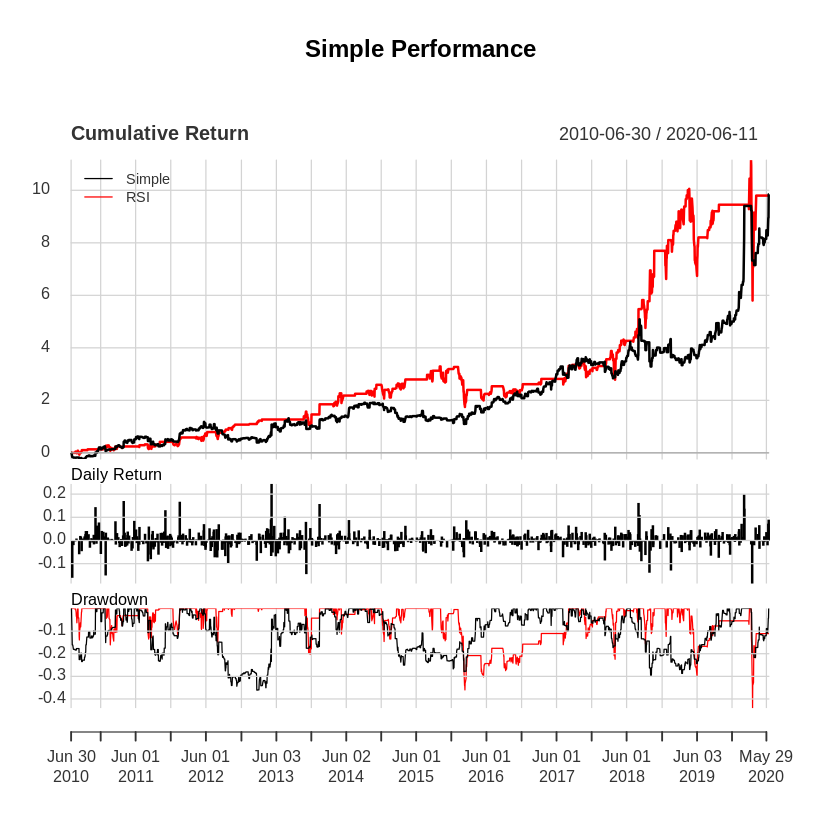

In [108]:
getSymbols("TSLA")
price_tsla <- Cl(TSLA) # close price
r_tsla <- price / Lag(price) - 1 # % of price change
delta_tsla <- .005 # threshold
signal_tsla <- c(0) # first date has no signal

# Loop over all trading days except the first
for(i in 2:length(price_tsla)){
  if(r_tsla[i] > delta_tsla){
    signal_tsla[i] <- 1
  } else
    signal_tsla[i] <- 0
}

signal_tsla <- reclass(signal_tsla, price_tsla)
trade_tsla <- Lag(signal_tsla, 1)
return_simple_tsla <- dailyReturn(TSLA) * trade_tsla
names(return_simple_tsla) = "filter"

day_tsla <- 14
price_tsla <- Cl(TSLA)
signal_tsla <- c(0)
rsi_tsla <- RSI(price_tsla, day_tsla)

signal_tsla[1:day + 1] <- 0

for(i in (day_tsla + 1):length(price_tsla)){
  if(rsi_tsla[i] < 45){
    signal_tsla[i] <- 1
  } else
    signal_tsla[i] <- 0
}
signal_tsla <- reclass(signal_tsla, Cl(TSLA))

trade_lag_tsla <- Lag(signal_tsla)
return_RSI_tsla <- dailyReturn(TSLA) * trade_lag_tsla

names(return_simple_tsla) = "Simple"
names(return_RSI_tsla) = "RSI"
return_combined_tsla = cbind(return_simple_tsla, return_RSI_tsla)
charts.PerformanceSummary(return_combined_tsla, name = "Simple filter vs RSI filter")